# HIV Methylation Age Advancement

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Setup.MethylationAgeModels import *

importing IPython notebook from Setup/MethylationAgeModels

In [3]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [4]:
hiv = (duration=='Control').map({False: 'HIV+', True: 'HIV-'})
hiv.name = 'HIV Status'

In [5]:
hiv.value_counts()

HIV+    137
HIV-     42
dtype: int64

## Run Age Predictions on HIV Dataset

In [59]:
def model_plot(prediction):
    fig, axs = subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
    plot_regression(age, prediction.ix[ti(hiv=='HIV-')], ax=axs[0])
    plot_regression(age, prediction.ix[ti(hiv=='HIV+')], ax=axs[1])
    axs[0].set_title('HIV-')
    axs[1].set_title('HIV+')

#### Hannum Model

In [60]:
pred = run_hannum_model(df_hiv)

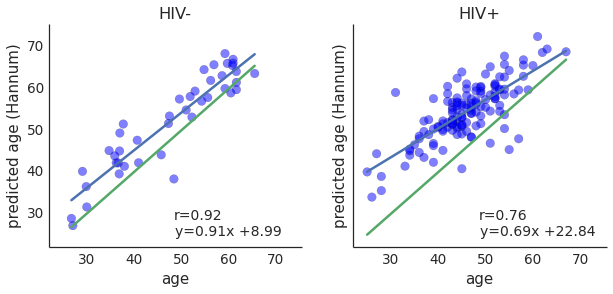

In [61]:
#Do not import
model_plot(pred)

In [62]:
get_error(age, pred, denominator='x', groups=hiv)

,HIV+,HIV-
% error,21.14,12.07
error (years),9.07,5.27


Preforming a linear adjustment on the control data.

In [63]:
reg = linear_regression(age, pred.ix[ti(duration=='Control')])
pred_adj = (pred - reg['intercept']) / reg['slope']

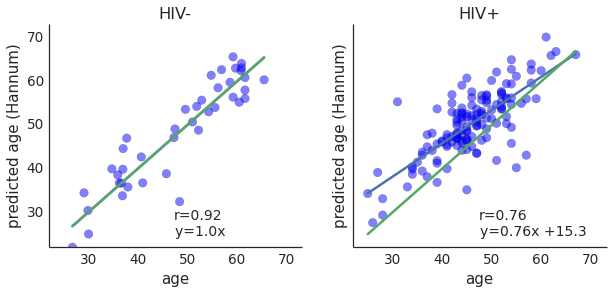

In [66]:
#Do not import
model_plot(pred_adj)

In [67]:
get_error(age, pred_adj, denominator='x', groups=hiv)

,HIV+,HIV-
% error,12.99,8.62
error (years),5.65,3.77


#### Horvath Model

In [68]:
pred_horvath = run_horvath_model(df_hiv_n)

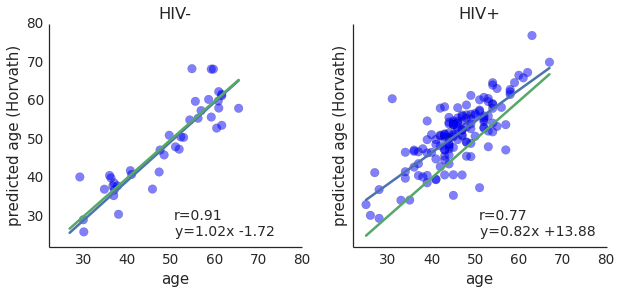

In [69]:
#Do not import
model_plot(pred_horvath)

In [70]:
reg = linear_regression(age, pred_horvath.ix[ti(duration=='Control')])
pred_horvath_adj = (pred_horvath - reg['intercept']) / reg['slope']

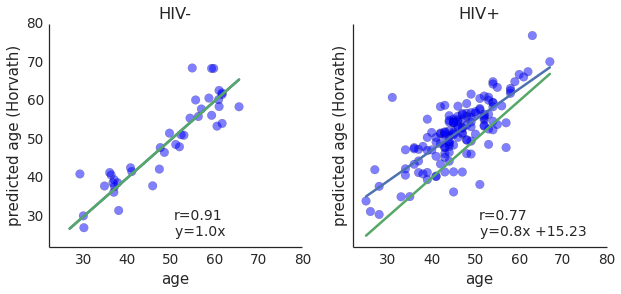

In [71]:
#Do not import
model_plot(pred_horvath_adj)

In [72]:
get_error(age, pred_horvath_adj, denominator='x', groups=hiv)

,HIV+,HIV-
% error,15.67,8.66
error (years),6.78,3.74


### Quality Control

* Look at detection p-value and concordance of the models

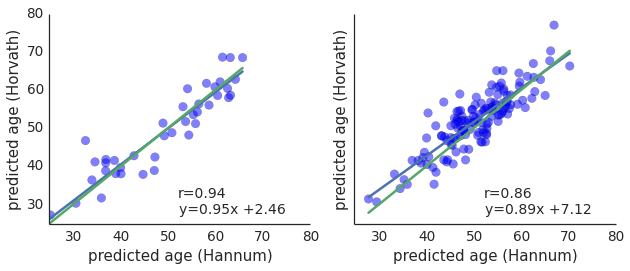

In [73]:
#Do not import
fig, axs = subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
plot_regression(pred_adj.ix[ti(hiv=='HIV-')], pred_horvath_adj, ax=axs[0])
plot_regression(pred_adj.ix[ti(hiv=='HIV+')], pred_horvath_adj, ax=axs[1])
fig.tight_layout()

In [74]:
get_error(pred_adj, pred_horvath_adj, groups=hiv)

,HIV+,HIV-
% error,7.05,7.66
error (years),3.56,3.38


### Dropping 6 patients with Low Concordance

* 2/6 have bad probes on the sites used in the models

In [75]:
diff = ((pred_adj - pred_horvath_adj) / ((pred_adj + pred_horvath_adj) * .5)).abs()
diff = diff.groupby(level=0).first()
diff.name = 'Absolute difference in models'

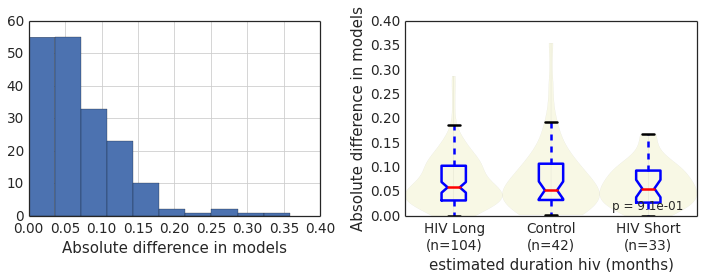

In [76]:
#Do not import
fig, axs = subplots(1,2, figsize=(10,4))
diff.hist(ax=axs[0])
axs[0].set_xlabel(diff.name)
violin_plot_pandas(duration, diff, ax=axs[1])
fig.tight_layout()

In [77]:
in_model = detection_p[detection_p.level_0.isin(hannum_model.index.union(horvath_model.index))]
(diff).ix[in_model.Sample_Name.unique()].dropna().order()

Sample_Name
METI-1     0.01
METI-24    0.02
METI-4     0.04
RP285      0.11
METI-5     0.13
RM067      0.14
RP126      0.29
METI-8     0.36
Name: Absolute difference in models, dtype: float64

In [78]:
pt = ti(diff < .2)

In [79]:
o = ti(diff > .2)
o

Index([u'METI-12', u'METI-8', u'RM292', u'RP040', u'RP126'], dtype='object', name=u'Sample_Name')

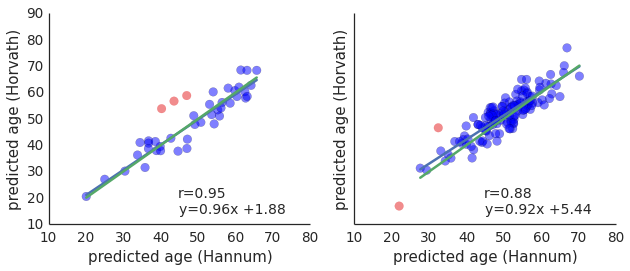

In [80]:
#Do not import
fig, axs = subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
plot_regression(pred_adj.ix[ti(hiv=='HIV-')].ix[pt], pred_horvath_adj, ax=axs[0])
plot_regression(pred_adj.ix[ti(hiv=='HIV+')].ix[pt], pred_horvath_adj, ax=axs[1])
series_scatter(pred_adj.ix[ti(hiv=='HIV-')].ix[o], pred_horvath_adj, ax=axs[1],
               color=colors[0], ann=None)
series_scatter(pred_adj.ix[ti(hiv=='HIV+')].ix[o], pred_horvath_adj, ax=axs[0],
               color=colors[0], ann=None)

fig.tight_layout()
fig.savefig(FIGDIR + 'hiv_model_agreement_filter.png', dpi=300)

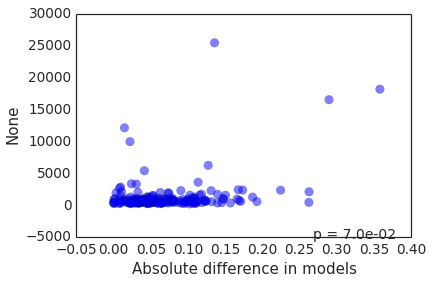

In [81]:
#Do not import
v = detection_p.groupby('Sample_Name').size()
series_scatter(diff, v)

In [82]:
detection_p[detection_p.Sample_Name.isin(o)].groupby('Sample_Name').size().order()

Sample_Name
RM292        463
METI-12     2123
RP040       2369
RP126      16562
METI-8     18208
dtype: int64

In [83]:
#pt = ti(((pred_adj - pred_horvath_adj)).abs().dropna() < 10)

#### Merging Hannum and Horvath  

Without filter.

In [84]:
pred_c = (pred_horvath_adj + pred_adj) / 2
pred_c = pred_c.ix[duration.index]
pred_c.name = 'Predicted Age (Combined)'
reg = linear_regression(age, pred_c.ix[ti(duration=='Control')])
pred_c = (pred_c - reg['intercept']) / reg['slope']

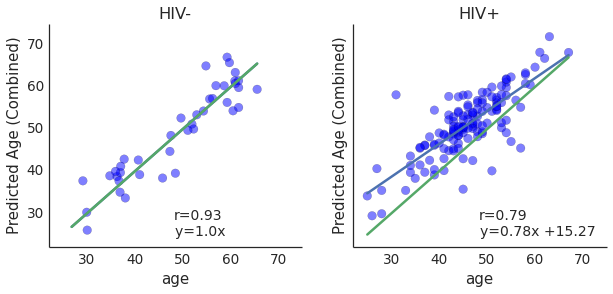

In [85]:
#Do not import
model_plot(pred_c)

In [86]:
get_error(age, pred_c, denominator='x', groups=hiv)

,HIV+,HIV-
% error,14.00,8.16
error (years),6.05,3.49


With QC filter

In [87]:
pred_c = (pred_horvath_adj + pred_adj) / 2
pred_c = pred_c.ix[duration.index].ix[pt]
pred_c.name = 'Predicted Age (Combined)'
reg = linear_regression(age, pred_c.ix[ti(duration=='Control')])
pred_c = (pred_c - reg['intercept']) / reg['slope']

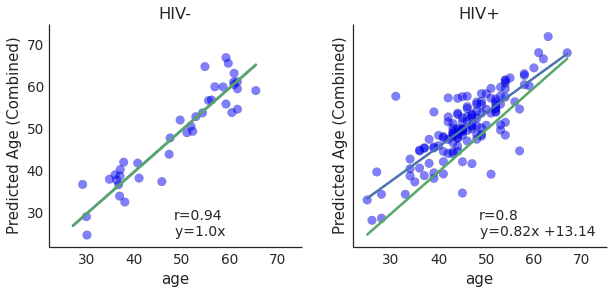

In [88]:
#Do not import
model_plot(pred_c)

In [89]:
get_error(age, pred_c, denominator='x', groups=hiv)

,HIV+,HIV-
% error,13.36,7.51
error (years),5.80,3.30


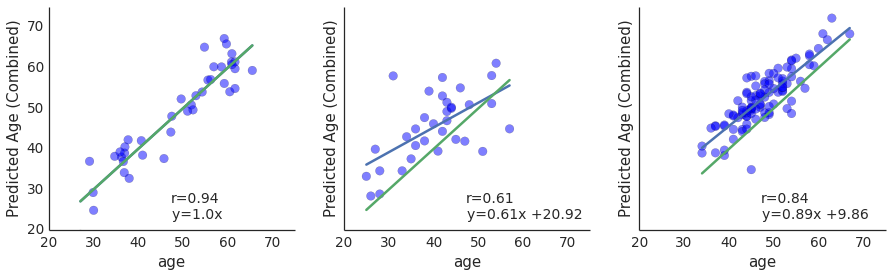

In [92]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
plot_regression(age, pred_c.ix[ti(duration=='Control')], ax=axs[0])
plot_regression(age, pred_c.ix[ti(duration=='HIV Short')], ax=axs[1])
plot_regression(age, pred_c.ix[ti(duration=='HIV Long')], ax=axs[2])
axs[2].set_xlim(20,75)
axs[2].set_ylim(20,75);

In [93]:
get_error(age, pred_c, denominator='x', groups=duration)

,Control,HIV Long,HIV Short
% error,7.51,11.50,19.08
error (years),3.30,5.32,7.26


### Comparing Age Advancement vs. Age Acceleration

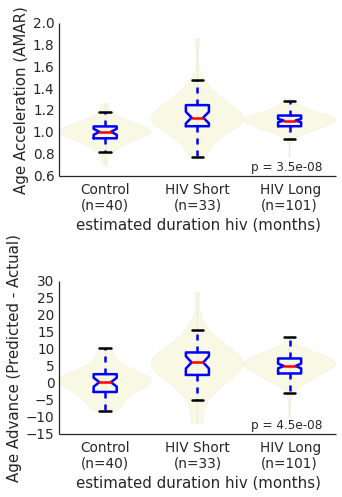

In [94]:
#Do not import
fig, axs = subplots(2,1, figsize=(5,7))

violin_plot_pandas(duration, pred_c / clinical.age, 
                   order=['Control','HIV Short','HIV Long'],
                   ax=axs[0])
axs[0].set_ylabel('Age Acceleration (AMAR)')

violin_plot_pandas(duration, pred_c - clinical.age, 
                   order=['Control','HIV Short','HIV Long'],
                   ax=axs[1])
axs[1].set_ylabel('Age Advance (Predicted - Actual)')

for ax in axs:
    prettify_ax(ax)
fig.tight_layout()

In [95]:
kruskal_pandas(duration.ix[ti(hiv == 'HIV+')], (pred_c - age))

H    0.16
p    0.69
dtype: float64

In [96]:
kruskal_pandas(hiv, (pred_c - age))

H    3.38e+01
p    6.03e-09
dtype: float64

In [97]:
(pred_c - age).dropna().groupby(hiv).mean()

HIV Status
HIV+    4.92e+00
HIV-    7.99e-16
dtype: float64

In [98]:
v = (pred_c - age).ix[duration.index].dropna()
v = (v - v.ix[ti(duration == 'Control')].mean()) / v.ix[ti(duration == 'Control')].std()

In [99]:
(v.ix[ti(hiv=='HIV+')] > 0).mean()

0.86861313868613144

In [100]:
((pred_c - age).ix[ti(hiv=='HIV+')] > 1).mean()

0.83211678832116787

### Looking at Predicted Time of Onset  
* The idea of age acceleration, only really makes sense in this context as a person should age normally until the onset of the disease

In [101]:
p2 = (pred_c - (clinical.age - (clinical['estimated duration hiv (months)'] / 12.)))
p2.name = 'Biological Time Since Onset'
a2 = (clinical['estimated duration hiv (months)'] / 12.)
a2.name = 'Actual Time Since Onset'
a2 = a2.ix[pt].dropna()
p2 = p2.ix[pt].dropna()

#### All HIV Combined

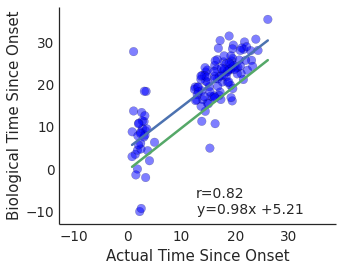

In [102]:
#Do not import
fig, ax = subplots(figsize=(5,4))
plot_regression(a2, p2, ax=ax)
fig.tight_layout()

In [103]:
#Do not import
p4 = p2 
a2.name = 'chron_age'
p4.name = 'bio_age'
df = process_factors([a2, p4], standardize=False)
fmla = robjects.Formula('bio_age ~ chron_age')
m = robjects.r.lm(fmla, df)
s = robjects.r.summary(m)
print '\n\n'.join(str(s).split('\n\n')[-3:])

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.2138     0.9326    5.59 1.25e-07 ***
chron_age     0.9790     0.0600   16.32  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.886 on 132 degrees of freedom
Multiple R-squared:  0.6685,	Adjusted R-squared:  0.666 
F-statistic: 266.2 on 1 and 132 DF,  p-value: < 2.2e-16




In [105]:
#Do not import
print robjects.r.confint(m)

                2.5 %   97.5 %
(Intercept) 3.3689637 7.058680
chron_age   0.8602881 1.097651



#### Short and Long Duration Split

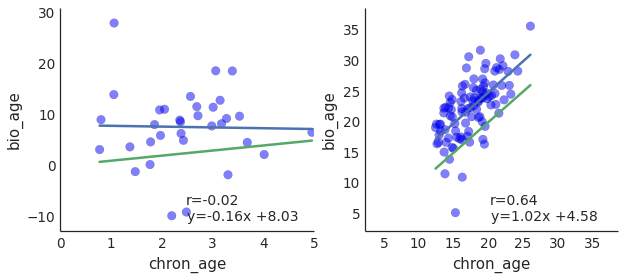

In [106]:
#Do not import
fig, axs = subplots(1,2, figsize=(10,4))
plot_regression(a2.ix[ti(duration=='HIV Short')], p2, ax=axs[0])
axs[0].set_xbound(0,5)
plot_regression(a2.ix[ti(duration=='HIV Long')], p2, ax=axs[1])